# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

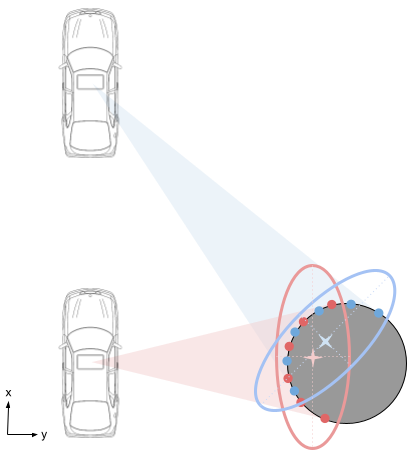

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample 25 points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

TODO- try translating data of 2nd scan forward and back to account for preliminary convergence of ICET- ideally, network should work with this as well

In [1]:
#setup - rememeber to switch to dnn kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
#import training data
#toy data set
d1 = np.loadtxt('training_data/scan1.txt')
d2 = np.loadtxt('training_data/scan2.txt')
gt = np.loadtxt('training_data/ground_truth.txt')

#slightly larger prism dataset
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth.txt")

points_per_sample = 25 #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)
# print(tf.shape(scan1))
# print(tf.shape(gt))

#split data into training and validation sets
tsplit = 0.99 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

# x_train = tf.reshape(x_train, [-1, 50, 1, 1, 1])
print(tf.shape(x_train))
# x_train = tf.reshape(x_train, [-1, 50, 3])

# print(x_train[0,0,:])

tf.Tensor([990  50   3], shape=(3,), dtype=int32)


In [3]:
#train network
from network import Net
# from network import permNet as Net
# from network import PointNet as Net
np.random.seed(1337)

runLen = 30

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.00035
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00005
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.MeanSquaredError())

summary = model.summary()
print(summary)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 64, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [callback, tensorboard_callback])
#add to callback to use stepped learning rate

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 3)]           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 3)             12        
_________________________________________________________________
dense (Dense)                (None, 50, 128)           512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 50, 256)           33024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 256)            0         
_________________________________________________________________
tf_op_layer_Transpose (Tenso [(None, 256, 2)]         

<IPython.core.display.Javascript object>


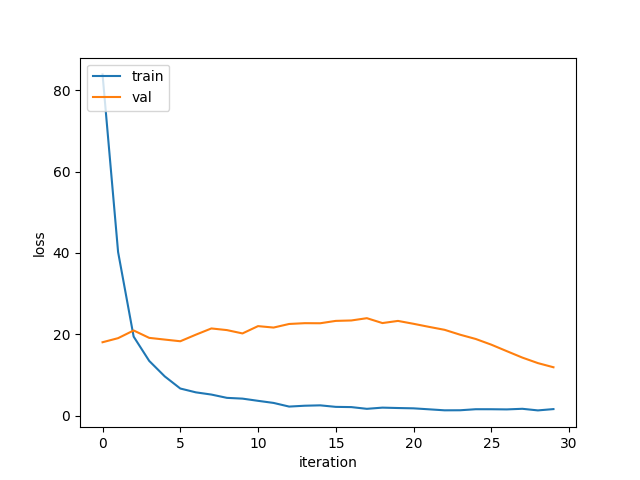

Text(0, 0.5, 'loss')

In [4]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [5]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])

estimates = model.predict(x_test[0:100:16])
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[0:100:16])

err = y_test[0:100:16] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

#MSE
print(tf.math.reduce_mean(tf.math.reduce_sum(err**2, axis = 1)/3))




estimated translation x y z
[[-3.4270854e+00 -1.7329353e+00 -1.3524627e-03]]
actual translation x y z
tf.Tensor([[-4.34160990e+00  8.27606079e-01  2.40832444e-03]], shape=(1, 3), dtype=float64)

 Error 
 tf.Tensor([[-0.9145245   2.56054139  0.00376079]], shape=(1, 3), dtype=float64)
tf.Tensor(2.4642471376826953, shape=(), dtype=float64)


<IPython.core.display.Javascript object>


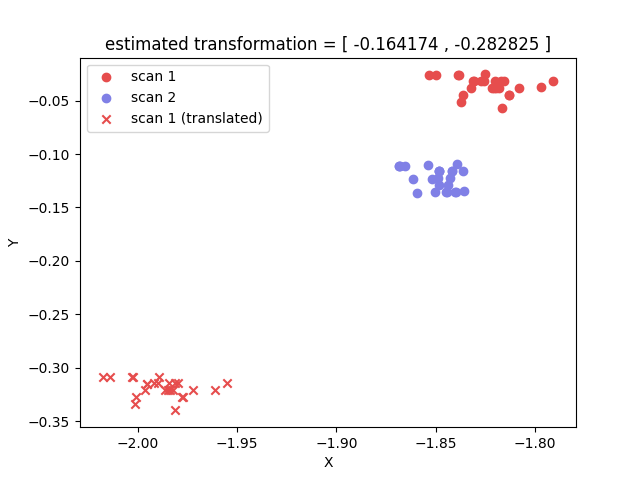

In [7]:
#visualize results of network on test data

#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = 5
#sample number (from x_test)
correction = 0.1*model.predict(x_test[n][None,:])[0]

ax1.scatter(x_test[n,:25,0].numpy(), x_test[n,:25,1].numpy(),
            color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(x_test[n,25:,0].numpy(), x_test[n,25:,1].numpy(),
            color = [0.5, 0.5, 0.9], label = 'scan 2')
ax1.scatter(x_test[n,:25,0].numpy() + correction[0], x_test[n,:25,1].numpy() + correction[1], marker = 'x',
            color = [0.9, 0.3, 0.3], label = 'scan 1 (translated)')
ax1.set_title("estimated transformation = [ %f , %f ]" %(correction[0], correction[1]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax1.legend(loc = 'best')

In [ ]:
#save network
# model.save("ffnet10k25.kmod")

#load network
# model = tf.keras.models.load_model("ffnet10k50.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.]])[None, :, :]
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)